In [62]:
import warnings
import pandas as pd
import numpy as np

from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

In [63]:
data = pd.read_csv('./weatherAUS.csv')
data.shape

(145460, 23)

In [64]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [65]:
data.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

In [66]:
data.isna().mean().sort_values(ascending=False)

Sunshine         0.480098
Evaporation      0.431665
Cloud3pm         0.408071
Cloud9am         0.384216
Pressure9am      0.103568
Pressure3pm      0.103314
WindDir9am       0.072639
WindGustDir      0.070989
WindGustSpeed    0.070555
Humidity3pm      0.030984
WindDir3pm       0.029066
Temp3pm          0.024811
RainTomorrow     0.022460
Rainfall         0.022419
RainToday        0.022419
WindSpeed3pm     0.021050
Humidity9am      0.018246
Temp9am          0.012148
WindSpeed9am     0.012148
MinTemp          0.010209
MaxTemp          0.008669
Location         0.000000
Date             0.000000
dtype: float64

In [67]:
data = data[data.columns[data.isna().mean().lt(0.35)]]

data = data.dropna(subset='RainTomorrow')

In [68]:
data_num = data.select_dtypes(include=np.number)
data_cat = data.select_dtypes(include='object')

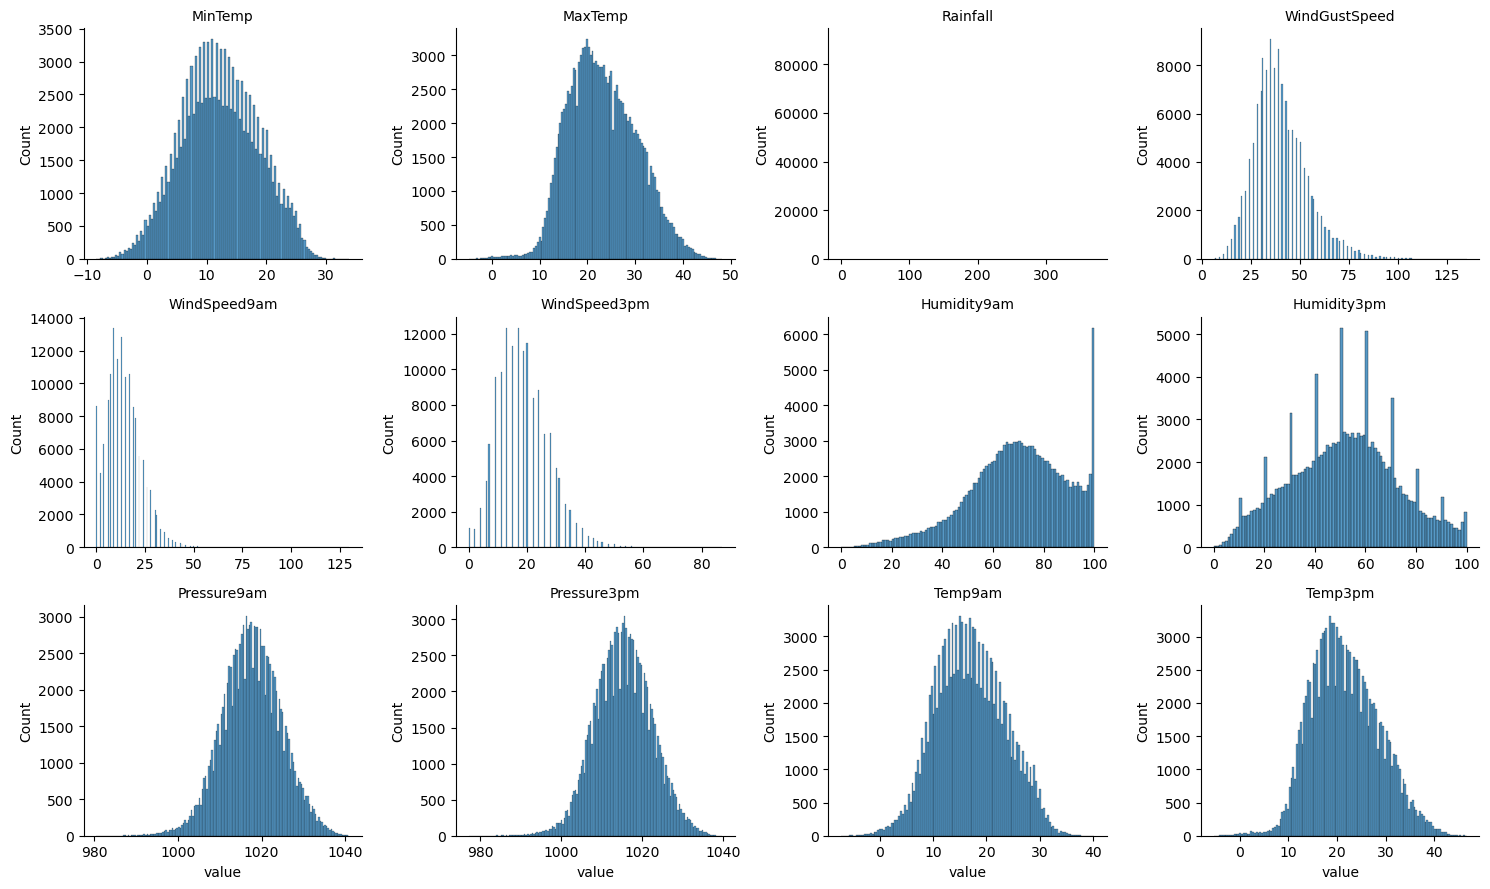

In [69]:
melted = data_num.melt()

g = sns.FacetGrid(melted,
                  col='variable',
                  col_wrap=4,
                  sharex=False,
                  sharey=False,
                  aspect=1.25)

g.map(sns.histplot, 'value')

g.set_titles(col_template='{col_name}')

g.tight_layout()

In [70]:
data_cat.nunique()

Date            3436
Location          49
WindGustDir       16
WindDir9am        16
WindDir3pm        16
RainToday          2
RainTomorrow       2
dtype: int64

In [71]:
data_cat['Date'] = pd.to_datetime(data['Date'])

data_cat[['Year', 'Month']] = (data_cat['Date']
                               .apply(lambda x:
                                      pd.Series([x.year, x.month])))
data_cat.drop('Date', axis=1, inplace=True)
data_num['Year'] = data_cat['Year']


In [72]:
max_year = data_cat['Year'].max()
X_train_num = data_num[data_num['Year'] < max_year]
X_test_num = data_num[data_num['Year'] == max_year]
y_train = data_cat[data_cat['Year'] < max_year]['RainTomorrow']
y_test = data_cat[data_cat['Year'] == max_year]['RainTomorrow']
data_cat.drop('RainTomorrow', axis=1, inplace=True)
X_train_cat = data_cat[data_cat['Year'] < max_year].drop('Year', axis=1)
X_test_cat = data_cat[data_cat['Year'] == max_year].drop('Year', axis=1)

In [73]:
num_imputer = SimpleImputer().set_output(transform='pandas')
X_train_num = num_imputer.fit_transform(X_train_num)
X_test_num = num_imputer.transform(X_test_num)

pd.concat([X_train_num, X_test_num]).isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
Year             0
dtype: int64

In [74]:
cat_imputer = SimpleImputer(
    strategy='most_frequent').set_output(transform='pandas')
X_train_cat = cat_imputer.fit_transform(X_train_cat)
X_test_cat = cat_imputer.transform(X_test_cat)

pd.concat([X_train_cat, X_test_cat]).isna().sum()

Location       0
WindGustDir    0
WindDir9am     0
WindDir3pm     0
RainToday      0
Month          0
dtype: int64

In [75]:
scaler = StandardScaler().set_output(transform='pandas')

X_train_num = scaler.fit_transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

In [76]:
encoder = (OneHotEncoder(drop='if_binary',
                         sparse_output=False)
           .set_output(transform='pandas'))

X_train_cat = encoder.fit_transform(X_train_cat)
X_test_cat = encoder.transform(X_test_cat)

X_train_cat.shape

(133727, 110)

In [77]:
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

X_train.shape

(133727, 123)

In [78]:
y_train.value_counts(normalize=True)

RainTomorrow
No     0.77481
Yes    0.22519
Name: proportion, dtype: float64

In [79]:
clf = (LogisticRegression(solver='liblinear',
                          class_weight='balanced',
                          random_state=42)
       .fit(X_train, y_train))

pred = clf.predict(X_test)

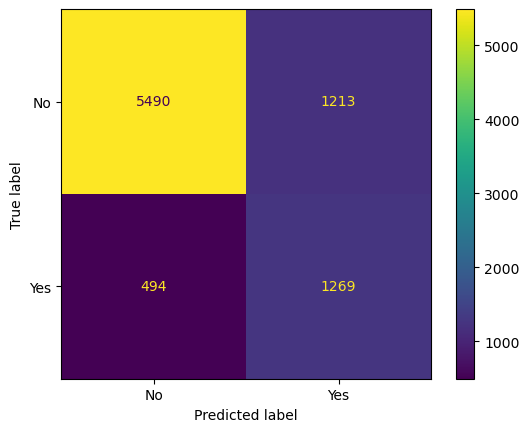

In [80]:
ConfusionMatrixDisplay.from_predictions(y_test, pred)

In [81]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          No       0.92      0.82      0.87      6703
         Yes       0.51      0.72      0.60      1763

    accuracy                           0.80      8466
   macro avg       0.71      0.77      0.73      8466
weighted avg       0.83      0.80      0.81      8466



### Аналіз отриманих результатів класифікації
1. Метрики моделі:
- No (Negative клас):

    - Precision: 0.92 — із усіх прогнозів класу "No" 92% були правильними.
    - Recall: 0.82 — із усіх реальних "No" 82% були правильно передбачені.
    - F1-score: 0.87 — це гармонійне середнє між precision і recall, що показує загальну якість передбачення для цього класу.
- Yes (Позитивний клас):

    - Precision: 0.51 — лише 51% прогнозів "Yes" правильні, що може вказувати на велику кількість помилкових позитивів.
    - Recall: 0.72 — модель правильно виявила 72% реальних "Yes".
    - F1-score: 0.60 — значення нижче середнього, що свідчить про труднощі у передбаченні класу "Yes".
2. Загальна точність (accuracy):
- Загальна точність: 0.80 — модель правильно передбачила 80% всіх прикладів.
3. Середні метрики:
- Macro avg враховує середнє значення для кожного класу:
    - Precision: 0.71, Recall: 0.77, F1-score: 0.73. Це свідчить, що класи мають дисбаланс у передбаченні.
- Weighted avg враховує кількість зразків у кожному класі:
    - Precision: 0.83, Recall: 0.80, F1-score: 0.81. Це показує загальний баланс, з урахуванням того, що клас "No" має значно більше прикладів.
### Висновок:
1. Дисбаланс класів:

    - Клас "No" (6703 приклади) домінує над класом "Yes" (1763 приклади). Модель краще працює з більшим класом.
    - Precision і F1-score для класу "Yes" значно нижчі, що вказує на проблеми з класифікацією менш представленого класу.
2. Якість моделі:

    - Модель добре працює з домінуючим класом "No", але її продуктивність щодо "Yes" вимагає покращення.
    - Загальна точність (80%) є прийнятною, але може бути обманливою через дисбаланс класів.

### Порівняння з попередньою моделлю:

### Покращення для обох класів:

##### Аналіз:
1. Клас "No":

    - У обох моделей precision однаковий (0.92), тобто частка правильних передбачень для "No" залишається стабільною.
    - Recall зріс із 0.79 до 0.82, що вказує на краще виявлення позитивних випадків класу "No".
    - F1-score покращився з 0.85 до 0.87, свідчачи про загальне поліпшення балансу між Precision і Recall.
2. Клас "Yes":

    - Precision для "Yes" у обох моделей однаковий (0.51), що вказує на стабільну частку правильних позитивних передбачень.
    - Recall трохи знизився із 0.76 до 0.72.
    - F1-score знизився незначно (з 0.61 до 0.60), що вказує на трохи гіршу продуктивність для класу "Yes".

3. Accuracy
    - Загальна точність зросла на 1%, що є незначним покращенням.

4. Macro Average
    - Precision зменшився на 0.01.
    - Recall трохи знизився (з 0.78 до 0.77).
    - F1-score залишився стабільним (0.73).

5. Weighted Average
    - Precision залишився на рівні 0.83.
    - Recall покращився на 0.01.
    - F1-score зріс із 0.80 до 0.81.

#### Висновки
1. Загальна продуктивність моделей схожа, але нова модель демонструє:
    - Трохи кращу точність (Accuracy).
    - Покращення для класу "No" за рахунок зростання Recall і F1-score.
2. Проте клас "Yes" дещо втратив Recall і F1-score, що може бути критичним залежно від задачі.
3. Якщо важливий клас "Yes", можливо, слід додатково налаштувати нову модель. Якщо ж головна мета — правильне розпізнавання "No", нова модель краще.